* It is trivial that shifting all images will not affect categorization performance
* Here we will leave the training images as-is, and shift the test images by a few pixels

In [4]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

# Data

In [5]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:, 1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

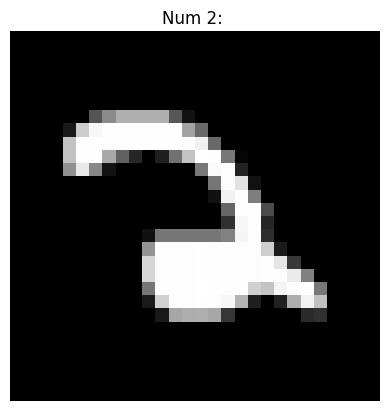

In [6]:
rand_row = np.random.randint(data.shape[0])
img = np.reshape(data_norm[rand_row], (28,28))
num = labels[rand_row]

plt.imshow(img, cmap = 'grey')
plt.title('Num %d: '%num)
plt.axis(False)
plt.show()

# Split

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Shift the test images by a few pixels

In [42]:
test_dataloader.dataset.tensors[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

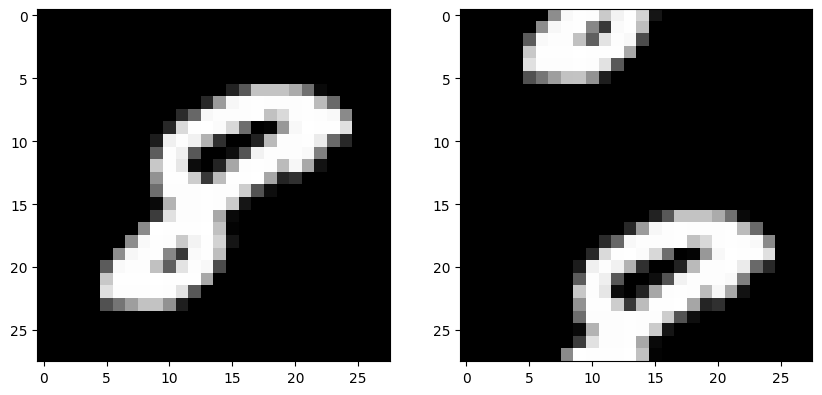

In [41]:
tmp = test_dataloader.dataset.tensors[0][0,:]
# tmp = test_dataloader.dataset.tensors[0][np.random.randint(test_data.shape[0])]

tmp = tmp.reshape(28,28)

shifted_tmp = torch.roll(tmp, shifts = 10, dims = 0)
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(tmp, cmap= 'grey')
ax[1].imshow(shifted_tmp, cmap = 'grey')
plt.show()

# Model

In [6]:
def ModelCreate(n_layers, n_units):

  class ModelArch(nn.Module):
    def __init__(self, n_layers, n_units):
      super().__init__()

      self.n_layers = n_layers
      self.layers = nn.ModuleDict()

      # Layers
      self.layers['input'] = nn.Linear(784, n_units)

      for i in range(n_layers):
        self.layers[f'hidden_{i}'] = nn.Linear(n_units, n_units)

      self.layers['output'] = nn.Linear(n_units, 10)

    def forward(self, x):
      x = self.layers['input'](x)

      for i in range(self.n_layers):
        x = self.layers[f'hidden_{i}'](x)

      x = self.layers['output'](x)

      return x

  ann = ModelArch(n_layers, n_units)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-2)

  return ann, loss_fn, optimizer